In [20]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import decimal

### Fonctions générales:

$\to$ On définit la fonction $W(n,P)$ qui génère une matrice $(W_{i,k})$ générée suivant une loi donnée centrée réduite avec $W^i_0 = 0$.



$\to$ On définit la fonction $\texttt{gen_X}(n,X_0,\sigma,\lambda, \delta,P, W)$ qui étant donné à un vecteur à $n$ dimensions de départ $X_0$ simule $P$ pas des actifs $X(P\delta) = (X_1(P\delta), \cdots, X_n(P\delta))$ où l'équation d'évolution est la suivante:
$$X_i(t_{k+1}) = X_i(t_k)e^{-\lambda \delta} + \mu(1-e^{-\lambda \delta})+ \sqrt{\delta} \sigma W_{i,k}  \text{ (équation 1)}$$

$\to$ Pour le cas particulier de $W_k^i$ i.i.d et suit la loi gaussienne centrée réduite, on fait la remarque que pour $k\in [|1,n|]$ et un temps $t_P = T$, $X_k(t_P)$ est somme de gaussiennes indépendantes, on déduit que $X_k(t_P)$ est aussi une variable gaussienne. Les caractéristiques de cette gaussienne se déduisent aisément par la relation de récurrence de l'équations $(1)$, pour $N\in \textbf{N}$, en notant $\mu_{N,k}$ la moyenne de cette gaussienne et $\sigma_{P,k}$ sa variance:
$$\begin{cases}
\mu_{P,k} = e^{-\lambda \delta}\mu + \mu(1-e^{-\lambda \delta})\\
\sigma_{P,k}^2 = e^{-2\lambda\delta}\sigma_{P-1,k}^2+ \delta \sigma^2 
\end{cases}
$$

On résout aisément, on trouve:
$$\mu_{P,k}  = \mu\text{ , }\sigma_{P,k}^2 = r(1-e^{-2P\lambda \delta}) \text{ où }r  =\dfrac{\delta \sigma^2}{1-e^{-2\lambda \delta}}$$
$\to$ On définit alors la fonction $\texttt{gen_X_particulier}(X_0,P,n,\sigma,\lambda, \delta)$ qui renvoie directement le résultat au temps $T$ d'une simulation.


On définit la fonction $\texttt{insolvance_1}(v, C)$ qui étant donné un vecteur $v =X(T)$ des actifs à l'écheance, renvoie la liste des banque insolvante. On fait la remarque suivante:
$$D_{k}^T = D_{k-1}^T\cup ( D_{k}^T -  D_{k-1}^T)$$

$\to$ On définit la fonction impact $I(X_0,P\propto T, F,R)$ où $F$ est le résultat de insolvance_1.

In [3]:
#####Fonctions générales
def W_1(n,P = 365):
    W_1 = np.random.randn(n,P)
    W_1[:, 0]= 0
    return W_1

def gen_X(X_0, W,P = 365, n =5, sigma = 8, lbda = 20, delta =1/365):
    A = np.full((n,P),0.0)
    A[:,0] = X_0
    for p in range(1,P):
        A[:,p] =A[:,p-1]*np.exp(-lbda*delta) + X_0*(1- np.exp(-lbda*delta))+np.sqrt(delta)*sigma *W[:,p]
    return A

def gen_X_particulier(X_0,N=1,P=365,n=5,sigma = 8,lbda = 20, delta = 1/365):
    mu_P =np.tile(X_0,(N,1))
    sigma_2 = delta*sigma**2 *(1-np.exp(-2*P*lbda*delta)) /(1-np.exp(-2*lbda*delta) )
    return X_0+np.sqrt(sigma_2)*np.random.normal(size = (N,1))

def insolvance_1(E,v, C, R = 0.05):
    assert len(v) == len(C)
    assert E.shape[0] == len(v) and E.shape[1] == len(v)
    used_up = np.full(len(v),False)
    l=-1
    while True:
        used_up+= v<C
        v = (v - (1-R)*np.sum(E*(used_up), axis = 1))*(v>=C)
        if (l == np.sum(used_up)):
            break
        l = np.sum(used_up)
    return used_up

def I(X,F,R = 0.05, P = 365):
    return np.sum((X + (1-R)*np.sum(E[~F], axis = 0))*(F))

vectorized_impact = np.vectorize(I, signature='(n),(n)->()')

def calculate_var_cvar(impacts, alpha):
    sorted_impacts=np.sort(impacts)
    #calculons value-at_risk
    var_index=int((1 - alpha) * len(sorted_impacts))
    var=sorted_impacts[var_index]
    #Conditional VAR
    cvar = np.mean(sorted_impacts[var_index:])
    return var, cvar

## Premier modèle: Capitaux indépendants

On s'interesse au calcul de différents quantités probabilisites relatifs aux $X_i$. On utilise les différents méthodes de simulations exposés lors des cours magistraux:

$\to$ Méthode de Monte-Carlo Naif.

$\to$ Méthode d'échantillonage d'importance.

$\to$ Méthode MCMC.

On estime les quantités suivantes:

$\to \textbf{P}(|D_n^T| = k)$ avec $k\in[|0,n|]$, la probabilité qu'on a insolvance d'exactement $k$ banques.

$\to$ Estimation de la Value-at-Risk et de la Conditional Value-at-Risk de la distribution $I(T)$ pour différents seuils $\alpha$ proches de $1$, ainsi que des intervalles de confiance associés aux estimateurs.

$\to$ Distribution de l’impact de défaut conditionnellement à l'effondrement du réseaux tout entier.

Pour ce cas particulier, $\textbf{ on utilise que les valeurs finaux de $X$}$, on se sert alors de la fonction $\texttt{gen_X_particulier}$.

#### Paramètres du modèle

On prend $n=5$. On se sert de la fonction $\texttt{gen_X_particulier}$. Plus tard on prend des valeurs assez grande de $n$.

In [5]:
####Constantes
N = 100000 #nombres de simulations
sigma = 8
lbda = 20
delta =1/365

In [6]:
## Hypothèse du premier modèle:
n = 5 
P = 365
sigma_2 = delta*sigma**2 *(1-np.exp(-2*P*lbda*delta)) /(1-np.exp(-2*lbda*delta) )
R = 0.05
E = np.array([[0,3,0,0,6],
              [3,0,0,0,0],
              [3,3,0,0,0],
              [2,2,2,0,2],
              [0,2,3,3,0]])

mu = 15. ## commune
c = 10 ## commune
X_0 = np.full(n,mu)
C = np.full(n,c)

In [2368]:
#Génération de de trajectoire de $n = 5$ banques entre $t=0$ et $t=T$
W = W_1(n)
X = gen_X(X_0,W)

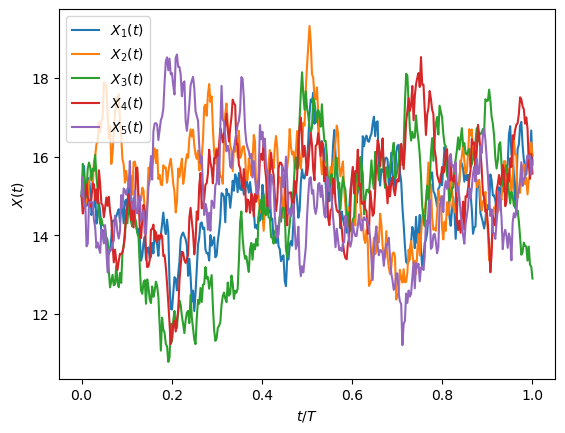

In [2410]:
#Visualisation
base = np.linspace(0,1, num =X.shape[1])
for j in range(X.shape[0]):
    plt.plot(base,X[j,:], label = '$X_'+str(j+1)+'(t)$')
plt.xlabel("$t/T$")
plt.ylabel('$X(t)$')
leg = plt.legend(loc=0)
plt.show()

## $\blacktriangleright$ Monte-Carlo Naif

In [2490]:
## Génération de $N$ trajectoires de $X$.
echantillons = gen_X_particulier(X_0,N)
insolvances = np.apply_along_axis(lambda v: insolvance_1(E,v,C,R), axis=1, arr=echantillons)
cardinaux = np.a pply_along_axis(lambda v: np.sum(v), axis = 1, arr = insolvances)
impacts = vectorized_impact(echantillons, insolvances)

### $\to \textbf{P}(|D_n^T| = k)$ avec $k\in[|0,n|]$.

On a $|D_n^T|= |D_n^T|(X)$ et donc pour des $(X_i)$ i.i.d, on a à $k$ fixé par TCL+Slutsky et LFN:
$$\overline{c}_k^N = \dfrac{1}{N}\sum_{k=1}^N \overbrace{\textbf{1}_{|D_n^T|(X_i)= k}}^{\text{i.i.d dans }\{0,1\}\text{, admet donc tous moment}}\xrightarrow[N\to +\infty]{}\textbf{P}(|D_n^T|(X)= k) =p_k$$
$$\dfrac{\sqrt{N}}{\sqrt{\overline{c}_k^N (1-\overline{c}_k^N)}}(\overline{c}_k^N - p_k)\xrightarrow[N\to +\infty]{\mathcal{L}}\mathcal{N}(0,1)$$
On obtient un intervalle de confiance, en notant $q$ la quantile d'ordre $0.95$ de la loi normale:
$$p_k \in[\overline{c}_k^N - \rho^N_k ,\overline{c}_k^N + \rho^N_k] \text{ où }\rho^N_k = q \dfrac{\sqrt{\overline{c}_k^N (1-\overline{c}_k^N)}}{\sqrt{N}}$$

Probabilités {0: 0.999947, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 5.3e-05}
Longueur des intervalles de confiance {0: 1.1974397821828555e-05, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 1.1974397821831974e-05}


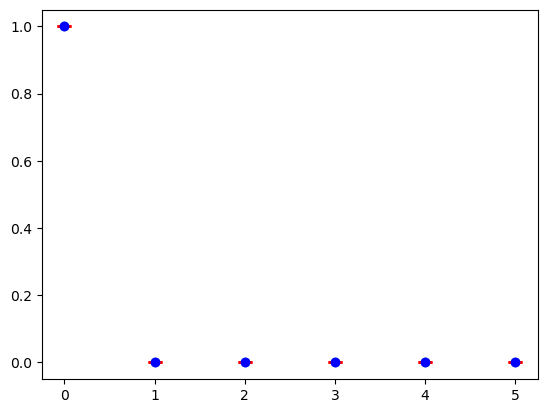

In [2499]:
## Génération de $N$ valeurs finaux de $X$ pour chaque k
probas = np.bincount(cardinaux, minlength = n+1)/N
q = stats.norm.ppf(0.95)
var = q *np.sqrt(probas*(1-probas))/np.sqrt(N)
plt.scatter(np.arange(n+1), probas)
plt.errorbar(np.arange(n+1),probas, yerr=var, fmt='o', color='b', ecolor='r', capsize=5, capthick=2)
plt.plot()
print('Probabilités', dict(zip(np.arange(n+1), probas)))
print('Longueur des intervalles de confiance', dict(zip(np.arange(n+1), var)))

### $\to$ Estimation de la Value-at-Risk et de la Conditional Value-at-Risk de la distribution $I(T)$ pour différents seuils $\alpha$ proches de $1$, ainsi que des intervalles de confiance associés aux estimateurs.

In [2491]:
##Simulation de nbr*N_reduit simulations
alphas = np.linspace(0.99, 1, num = 10)
nbr = 10
varL = np.full((nbr, alphas.shape[0]),0)
cvarL = np.full((nbr, alphas.shape[0]),0)
for nb in range(nbr):
    echantillons = gen_X_particulier(X_0,N)
    insolvances = np.apply_along_axis(lambda v: insolvance_1(E,v,C,R), axis=1, arr=echantillons)
    impacts = vectorized_impact(echantillons, insolvances)
    for i in range(len(alphas)):
        alpha = alphas[i]
        var, cvar = calculate_var_cvar(impacts, alpha)
        varL[nb,i] = var
        cvarL[nb,i] = cvar

[]

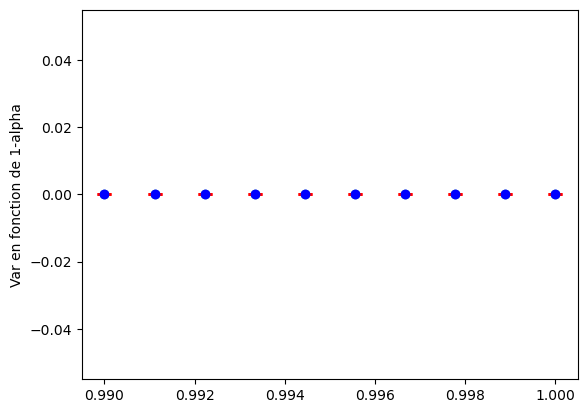

In [2473]:
varA = np.mean(varL,axis = 0)
varvar = np.var(varL, axis =0)
plt.scatter(alphas, varA)
plt.errorbar(alphas,varvar, yerr=var, fmt='o', color='b', ecolor='r', capsize=5, capthick=2)
plt.ylabel('Var en fonction de 1-alpha')
plt.plot()

[]

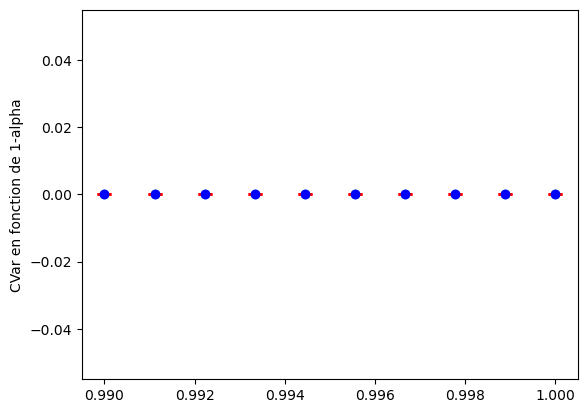

In [2474]:
cvarLA =np.mean(cvarL,axis = 0)
varvarLA = np.var(cvarL, axis =0)
plt.scatter(alphas, cvarLA)
plt.errorbar(alphas,varvarLA, yerr=var, fmt='o', color='b', ecolor='r', capsize=5, capthick=2)
plt.ylabel('CVar en fonction de 1-alpha')
plt.plot()


In [2486]:
## Distribution de I(T) condtionnelle
dist = impacts[cardinaux == n]

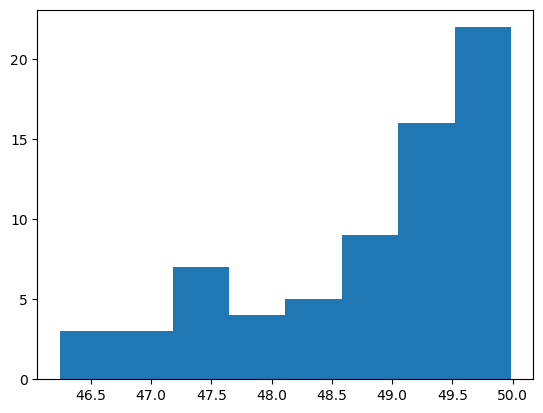

In [2489]:
plt.hist(dist, bins='auto')
plt.show()

En ce basant sur ces résultats, la méthode de Monte Carlo $\textbf{n'est pas suffisante}$. Nous optons pour d'autre méthodes dite de réduction de variance, comme suit:

## $\blacktriangleright$ Échantillonage d'importance (Importance splitting)

L'idée est utiliser l'échantillonage par importance avec une distribution de telle manière à augmenter la probabilité que $|D_n^T|$ prennent des valeurs elevées, on propose de réduire $\mu$ en $\mu'$ de telle manière qu'il y'a plusieurs fois la réalisation de $X_i\leq c_i$. On pose alors:
$$X' \hookrightarrow \mathcal{N}\bigg(\mu' I_n, \dfrac{\delta \sigma^2}{1- e^{-2\lambda \delta}} (1- e^{-\lambda T}) I_n\bigg) $$
On note $f^n_{\mu, \sigma}$ la densité de la loi $\mathcal{N}(\mu I_n, \sigma^2 I_n)$. On a alors:
$$\textbf{P}(|D_n^T| = k) = \textbf{E}_X\bigg[\textbf{1}_{|D_n^T|(X) = k}\bigg] =  \textbf{E}_{X'}\bigg[\textbf{1}_{|D_n^T|(X') = k} \dfrac{f^n_{\mu, \sigma_N}(X)}{f^n_{\mu', \sigma_N}(X')}\bigg]=\textbf{E}_{X'}\bigg[\textbf{1}_{|D_n^T|(X') = k} \cdot \text{exp}\bigg(\dfrac{\sum_{i=1}^n (X'_i-\mu')^2 -(X'_i-\mu)^2  )}{2\sigma_N^2}\bigg)\bigg]$$

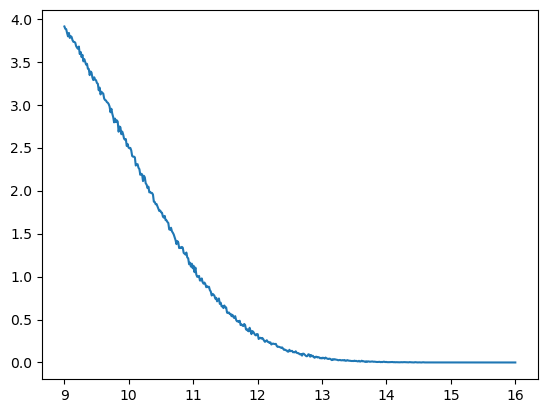

In [2540]:
### Recherche empirique d'un mu prime optimal
mu_primes = np.linspace(min(C)-1,mu+1,num = 500 )
d_mu_p = np.full_like(mu_primes,0) 
cards = np.full_like(mu_primes,0) 
for i in range(len(mu_primes)):
    mu_prime = mu_primes[i]
    Xp_0 =np.full(n,mu_prime)
    echantillons = gen_X_particulier(Xp_0,10000)
    insolvances = np.apply_along_axis(lambda v: insolvance_1(E,v,C,R), axis=1, arr=echantillons)
    cardinaux = np.apply_along_axis(lambda v: np.sum(v), axis = 1, arr = insolvances)
    d_mu_p[i] = np.mean(cardinaux)
    cards[i] = len(np.unique(cardinaux))/(n+1)
plt.plot(mu_primes, d_mu_p)
plt.show()

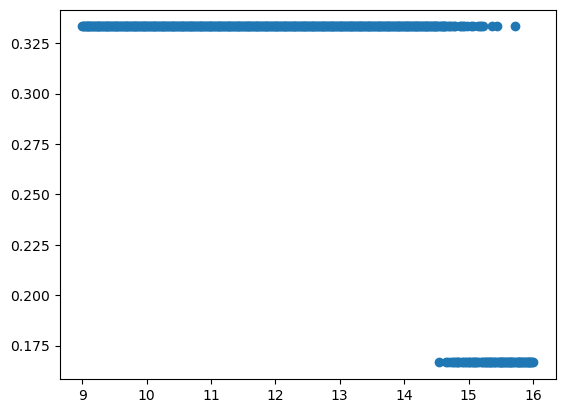

In [2543]:
plt.scatter(mu_primes, cards)
plt.show()

On prend $\mu' = 11$. On envisage le problème calculatoire suivant:

In [42]:
### Problème calculatoire!
theta = 1
X = np.random.randn(1000)
s= np.exp(- theta**2 +2*(theta)*X)
s_p = np.exp((X)**2 - (X-theta)**2)
print(max(np.unique(s-s_p)))

2.2737367544323206e-13


In [3217]:
Xp_0 =np.full(n,mu_p)
echantillons = gen_X_particulier(Xp_0,N)
insolvances = np.apply_along_axis(lambda v: insolvance_1(E,v,C,R), axis=1, arr=echantillons)
cardinaux  = np.apply_along_axis(lambda v: np.sum(v), axis = 1, arr = insolvances)
classes = np.full(n+1,0)
for i in range(echantillons.shape[0]):
    norm_dec= decimal.Decimal((np.sum(((echantillons[i] - Xp_0 )**2 - (echantillons[i]-X_0)**2))/(2*sigma_2)))
    classes[cardinaux[i]] += norm_dec.exp()
print(classes/np.sum(classes))

[1. 0. 0. 0. 0. 0.]


In [21]:
echantillons=gen_X_particulier(X_0,100000)
insolvances = np.apply_along_axis(lambda v: insolvance_1(E,v,C,R), axis=1, arr=echantillons)

[[False False False False False]
 [False False False False False]
 [False False False False False]
 ...
 [False False False False False]
 [False False False False False]
 [False False False False False]]
